In [1]:
# Author: Samantha Tetef
# Created: 4.19.21
# Title: GP_BUCB_Example

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import itertools

from sklearn.gaussian_process import GaussianProcessRegressor

## Testing UCB1, GP-UCG, and  GP_BUCB algorithms

### Creating synthetic data

In [220]:
N = 1000
X = np.linspace(0,1,N)

# parameter space
coeffs = np.linspace(-3,3,21)
print(f"Possible coeffs: {coeffs}")

# all possible actions
Action_Set = np.array(list(itertools.product(coeffs, repeat=3)))
num_permutes = Action_Set.shape[0]
print(f"Actions set shappe: {Action_Set.shape}")

Possible coeffs: [-3.  -2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9
  1.2  1.5  1.8  2.1  2.4  2.7  3. ]
Actions set shappe: (9261, 3)


In [221]:
Y = np.zeros((num_permutes,N))
# targets are polynomial using actions as coeffs
for i in range(num_permutes):
    Y[i,:] = Action_Set[i,0]*X**2 + Action_Set[i,1]*X + Action_Set[i,2]

# adding normal noise for variation
noise = np.random.normal(loc=0.0, scale=0.1, size=(num_permutes,N))
Y = Y + noise

print(Y.shape)

(9261, 1000)


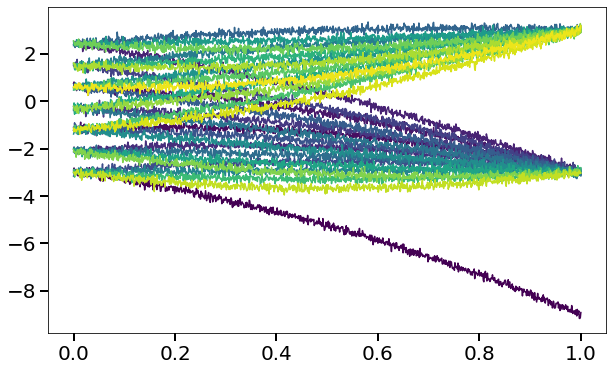

In [224]:
# displaying data
fig, ax = plt.subplots(figsize=(10,6))
fontsize = 16

Colors= plt.cm.viridis(np.arange(num_permutes)/(num_permutes+1))

for i in range(num_permutes):
    if not i % 300:
        plt.plot(X, Y[i], '-', c=Colors[i], label=f'${Action_Set[i,0]}x^2+{Action_Set[i,1]}x+{Action_Set[i,1]}$')

plt.xticks(fontsize=fontsize+4)
plt.yticks(fontsize=fontsize+4)

ax.tick_params(direction='out', width=2, length=8)
ax.tick_params(direction='out', which='minor', width=1, length=5)

# plt.legend(fontsize=fontsize)
plt.show()

In [225]:
# create wanted "target"
target_action = (-1.7, 0.1, 0.1)
target = target_action[0]*X**2 + target_action[1]*X + target_action[2]

In [226]:
def MSE(Y, target):
    return np.sum((Y-target)**2, axis=1)/Y.shape[0]

In [227]:
mse = np.round(MSE(Y, target), 1)

In [228]:
# create dataframe
columns = ['a', 'b', 'c']
df = pd.DataFrame(data=Action_Set, columns=columns)
df['MSE'] = mse
df['index'] = np.arange(len(Action_Set))
df

,a,b,c,MSE,index
0,-3.0,-3.0,-3.0,3.0,0
1,-3.0,-3.0,-2.7,2.6,1
2,-3.0,-3.0,-2.4,2.3,2
3,-3.0,-3.0,-2.1,2.1,3
4,-3.0,-3.0,-1.8,1.8,4
...,...,...,...,...,...
9256,3.0,3.0,1.8,2.9,9256
9257,3.0,3.0,2.1,3.3,9257
9258,3.0,3.0,2.4,3.6,9258
9259,3.0,3.0,2.7,3.9,9259


In [229]:
def ucb1_policy(df, t, ucb_scale=2.0):
    '''
    Applies GP-BUCB policy to generate recommendations.
    
    This is adapted from the tutorial found at
    https://jamesrledoux.com/algorithms/bandit-algorithms-epsilon-ucb-exp-python/
    
    Arguments:
        df - dataset on which to apply UCB policy
            type == dataframe
        t - current time step (start at 1)
            type == int
        ucb_scale - the scale of the upper bound
            default = 2.0
            type == float
    Returns:
        actions - a subset of the data with the highest ucb
            type == dataframe        
    '''
    N = 100
    d = 3
    ads_selected = []
    numbers_of_selections = [0] * d
    sums_of_reward = [0] * d
    total_reward = 0

    for n in range(0, N):
        ad = 0
        max_upper_bound = 0
        for i in range(0, d):
            if (numbers_of_selections[i] > 0):
                average_reward = sums_of_reward[i] / numbers_of_selections[i]
                delta_i = np.sqrt(2 * np.log(n+1) / numbers_of_selections[i])
                upper_bound = average_reward + delta_i
            else:
                upper_bound = 1e400
            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound
                ad = i
        ads_selected.append(ad)
        numbers_of_selections[ad] += 1
        reward = -df['MSE'].values[n]
        sums_of_reward[ad] += reward
        total_reward += reward

    return ads_selected

# res = ucb1_policy(df, 1)
# pd.Series(res).tail(100).value_counts(normalize=True)

In [230]:
summary_df = df[['index', 'MSE']].groupby('index')
summary_df = summary_df.agg(['mean', 'count', 'std'])
summary_df

MSE          
      mean count std
index               
0      3.0     1 NaN
1      2.6     1 NaN
2      2.3     1 NaN
3      2.1     1 NaN
4      1.8     1 NaN
...    ...   ...  ..
9256   2.9     1 NaN
9257   3.3     1 NaN
9258   3.6     1 NaN
9259   3.9     1 NaN
9260   4.3     1 NaN

[9261 rows x 3 columns]

In [189]:
t = 1
ucb_scale=2
for colm in columns: 
    summary_df['ucb'] = summary_df[(colm, 'mean')] \
        + ucb_scale * summary_df[(colm, 'std')] / np.sqrt(summary_df[(colm, 'count')])
#     summary_df[(colm, 'ucb')] = summary_df[(colm, 'mean')] \
#         + ucb_scale * summary_df[(colm, 'std')] / np.sqrt(summary_df[(colm, 'count')])
summary_df

a                         b                         c        \
          mean count       std      mean count       std      mean count   
MSE                                                                        
0.0  -0.785714     7  0.859125 -0.928571     7  0.975900  0.285714     7   
0.1  -1.166667    18  0.822478 -0.277778    18  0.958280  0.111111    18   
0.2  -0.263158    19  0.948221 -1.026316    19  0.920050  0.210526    19   
0.3  -0.970588    17  0.837977 -0.382353    17  1.038770  0.117647    17   
0.4  -0.605263    19  1.328940 -0.552632    19  1.268143  0.026316    19   
...        ...   ...       ...       ...   ...       ...       ...   ...   
21.3  2.000000     1       NaN  2.000000     1       NaN  1.500000     1   
21.8  1.000000     1       NaN  2.000000     1       NaN  2.000000     1   
23.2  2.000000     1       NaN  1.500000     1       NaN  2.000000     1   
24.1  1.500000     1       NaN  2.000000     1       NaN  2.000000     1   
26.6  2.000000     1       NaN  2.000000     1       NaN  2.000000     1   

                     index                           a         b         c  
           std        mean count         std       ucb       ucb       ucb  
MSE                                                                         
0.0   0.267261  220.571429     7  122.708132 -0.136277 -0.190860  0.487745  
0.1   0.366042  170.222222    18  121.210345 -0.778947  0.173960  0.283665  
0.2   0.480619  303.315789    19  144.178536  0.171916 -0.604168  0.431049  
0.3   0.625735  200.117647    17  130.396934 -0.564110  0.121525  0.421173  
0.4   0.655610  256.052632    19  204.733288  0.004496  0.029232  0.327130  
...        ...         ...   ...         ...       ...       ...       ...  
21.3       NaN  727.000000     1         NaN       NaN       NaN       NaN  
21.8       NaN  566.000000     1         NaN       NaN       NaN       NaN  
23.2       NaN  719.000000     1         NaN       NaN       NaN       NaN  
24.1       NaN  647.000000     1         NaN       NaN       NaN       NaN  
26.6       NaN  728.000000     1         NaN       NaN       NaN       NaN  

[149 rows x 15 columns]

In [190]:
scores = summary_df.sort_values((columns[0], 'ucb'), ascending=False)
scores

a                     b                         c        \
          mean count       std  mean count       std      mean count   
MSE                                                                    
10.7  0.000000     2  2.828427  1.00     2  1.414214  1.750000     2   
12.2  0.250000     2  2.474874  0.75     2  1.767767  2.000000     2   
7.7   0.250000     2  2.474874  0.00     2  2.121320 -0.750000     2   
15.6  0.750000     2  1.767767  1.50     2  0.707107  1.750000     2   
10.0  0.666667     3  1.892969  0.50     3  1.322876  1.666667     3   
...        ...   ...       ...   ...   ...       ...       ...   ...   
21.3  2.000000     1       NaN  2.00     1       NaN  1.500000     1   
21.8  1.000000     1       NaN  2.00     1       NaN  2.000000     1   
23.2  2.000000     1       NaN  1.50     1       NaN  2.000000     1   
24.1  1.500000     1       NaN  2.00     1       NaN  2.000000     1   
26.6  2.000000     1       NaN  2.00     1       NaN  2.000000     1   

                     index                          a         b         c  
           std        mean count         std      ucb       ucb       ucb  
MSE                                                                        
10.7  0.353553  385.500000     2  432.042243  4.00000  3.000000  2.250000  
12.2  0.000000  422.000000     2  369.109740  3.75000  3.250000  2.000000  
7.7   1.060660  403.000000     2  441.234631  3.75000  3.000000  0.750000  
15.6  0.353553  516.000000     2  272.943218  3.25000  2.500000  2.250000  
10.0  0.577350  484.333333     3  288.766919  2.85248  2.027525  2.333333  
...        ...         ...   ...         ...      ...       ...       ...  
21.3       NaN  727.000000     1         NaN      NaN       NaN       NaN  
21.8       NaN  566.000000     1         NaN      NaN       NaN       NaN  
23.2       NaN  719.000000     1         NaN      NaN       NaN       NaN  
24.1       NaN  647.000000     1         NaN      NaN       NaN       NaN  
26.6       NaN  728.000000     1         NaN      NaN       NaN       NaN  

[149 rows x 15 columns]

In [137]:
n = 3
ucb_headings = [(colm, 'ucb') for colm in columns]
ucb_scores = summary_df[ucb_headings]
ucb_scores
# recs = scores.loc[scores.index[:n], (columns[0], 'ucb')].values
# recs

,a,b,c
,ucb,ucb,ucb
MSE,,,
1.302777,-2.0,1.0,0.0
1.948551,-1.0,-2.0,1.0
3.709984,-2.0,1.0,-1.0
6.518392,-2.0,1.0,-0.5
7.565368,-1.0,-2.0,2.0
...,...,...,...
2387.633882,2.0,2.0,-1.0
2563.866915,2.0,1.0,2.0


In [138]:
ucb_scores.max(axis=0)

a  ucb    2.0
b  ucb    2.0
c  ucb    2.0
dtype: float64